In [2]:
#!pip3 install numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime
from datetime import timedelta
import RPi.GPIO as GPIO
import time
import progressbar
%matplotlib inline  

In [26]:
#assign pin numbers
msd501pm10pin=5
msd501pm25pin=6
nova10pin=23
nova25pin=24

#set data variables
datasize=100


In [30]:
def setupGPIO(pin,mode): #mode is either in or out
    GPIO.setmode(GPIO.BCM)
    if mode=="in": 
        GPIO.setup(pin, GPIO.IN)
    else:
        GPIO.setup(pin, GPIO.OUT)
        





def readpulse(pin):
    for i in range(2):
        start = datetime.now().microsecond
        stop = datetime.now().microsecond
        while GPIO.input(pin) == 0:
            continue
        start = datetime.now().microsecond
        while GPIO.input(pin) == 1:
            continue
        stop = datetime.now().microsecond
        Elapsed = stop - start
    return Elapsed


def checkarray(pulseinfonova): #### check the generated array
    print(pulseinfonova['pulsewidth10'])
    print(pulseinfonova['pulsewidth25'],"\n\n")
    pp.pprint(pulseinfonova)
    
#generate dataframe
def generatedf(pulseinfonova):
    df=pd.DataFrame({'time':pulseinfonova['time'],
                  'pulsewidth10':pulseinfonova['pulsewidth10'],
                  'pulsewidth25':pulseinfonova['pulsewidth25'],
                  'dust10(ng)':pulseinfonova['pulsewidth10']-2000,
                  'dust10(ug)':(pulseinfonova['pulsewidth10']-2000)/1000,
                  'dust25(ng)':pulseinfonova['pulsewidth25']-2000,
                  'dust25(ug)':(pulseinfonova['pulsewidth25']-2000)/1000,  
                  "time(s)":pulseinfonova['second']/1000})
    #add info
    df["dust10(ppm)"]=df['dust10(ug)']*1.225
    df["dust25(ppm)"]=df['dust25(ug)']*1.225
    df["rolling mean 10(ppm)"] = df["dust10(ppm)"].rolling(10,center=True).mean()
    df["rolling mean 25(ppm)"] = df["dust25(ppm)"].rolling(10,center=True).mean()
    df.fillna(method='bfill',inplace=True)
    df["error10"]= np.power(np.power(df["rolling mean 10(ppm)"]-df["dust10(ppm)"],2),0.4)
    df["error25"]= np.power(np.power(df["rolling mean 25(ppm)"]-df["dust25(ppm)"],2),0.4)
    #fill in na just in case
    df.fillna(method='bfill',inplace=True)
    df.fillna(method='ffill',inplace=True)
    return df

def testpulse(pin,periods):
    end_time = datetime.now() + timedelta(seconds=20)
    count=0
    while count<periods:
        #time.sleep(1)
        #print(GPIO.input(23))
        dustlevel= float(readpulse(pin)+1-1)/1000-2
        print("the dust level is :", dustlevel)
        count+=1
        
        
        
def readpulsewidth(pin10,pin25,number_of_readings):
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    time=[]
    second=np.array([])
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,datetime.now().microsecond)
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second}

In [21]:
#set up gpio
setupGPIO(nova10pin,"in")
setupGPIO(nova25pin,"in")


In [22]:
#run test for output
print("testing nova 10")
testpulse(nova10pin,5)
print("testing nova 25")
testpulse(nova25pin,5)

testing nova 10
the dust level is : 28.935
the dust level is : 28.939
the dust level is : 28.945
the dust level is : 28.945
the dust level is : 28.947
testing nova 25
the dust level is : 33.934
the dust level is : 34.93
the dust level is : 34.938
the dust level is : 33.937
the dust level is : 33.932


In [27]:
#call data
pulseinfonova=readpulsewidth(nova10pin,nova25pin,datasize)
checkarray(pulseinfonova)
df=generatedf(pulseinfonova)

100% (100 of 100) |######################| Elapsed Time: 0:05:15 Time:  0:05:15


[30943. 30948. 30942. 30941. 30948. 30947. 30946. 30938. 30948. 30944.
 30947. 30946. 30940. 30944. 30941. 30939. 29942. 29946. 29949. 29947.
 29946. 29946. 28950. 28948. 29945. 29954. 29944. 29951. 29951. 29948.
 29950. 29947. 29945. 29948. 29952. 29948. 30945. 30947. 29951. 29948.
 29946. 29951. 29945. 29946. 29951. 29952. 29944. 28953. 28952. 29951.
 29949. 29954. 29951. 29949. 29947. 29948. 30945. 31948. 31945. 31945.
 31942. 31945. 30940. 30950. 31946. 31945. 30945. 30946. 30949. 29948.
 30943. 30946. 30947. 30942. 30943. 30937. 30943. 30949. 30945. 30949.
 30946. 30941. 30953. 30946. 29952. 30952. 30952. 29954. 29954. 30943.
 29948. 29953. 29948. 29939. 29950. 29946. 29949. 29949. 29946. 29951.]
[37932. 37934. 37933. 37931. 37936. 37935. 37936. 36937. 37934. 36940.
 37932. 37932. 38925. 38935. 38933. 37924. 36932. 36936. 35933. 36934.
 35935. 34933. 33940. 33942. 34939. 34942. 34940. 34942. 33942. 33942.
 33940. 34935. 34941. 34940. 33944. 33945. 34939. 34938. 34941. 34937.
 3494

In [31]:
df.head(20)

,dust10(ng),dust10(ug),dust25(ng),dust25(ug),pulsewidth10,pulsewidth25,time,time(s),dust10(ppm),dust25(ppm),rolling mean 10(ppm),rolling mean 25(ppm),error10,error25
0,28943.0,28.943,35932.0,35.932,30943.0,37932.0,2019-02-01 08:41:27,956.952,35.455175,44.016700,35.457012,43.775130,0.006477,0.320948
1,28948.0,28.948,35934.0,35.934,30948.0,37934.0,2019-02-01 08:41:30,963.707,35.461300,44.019150,35.457012,43.775130,0.012757,0.323549
2,28942.0,28.942,35933.0,35.933,30942.0,37933.0,2019-02-01 08:41:33,970.697,35.453950,44.017925,35.457012,43.775130,0.009747,0.322249
3,28941.0,28.941,35931.0,35.931,30941.0,37931.0,2019-02-01 08:41:36,977.548,35.452725,44.015475,35.457012,43.775130,0.012757,0.319645
4,28948.0,28.948,35936.0,35.936,30948.0,37936.0,2019-02-01 08:41:39,984.269,35.461300,44.021600,35.457012,43.775130,0.012757,0.326145
5,28947.0,28.947,35935.0,35.935,30947.0,37935.0,2019-02-01 08:41:42,991.486,35.460075,44.020375,35.457012,43.775130,0.009747,0.324848
6,28946.0,28.946,35936.0,35.936,30946.0,37936.0,2019-02-01 08:41:45,998.506,35.458850,44.021600,35.457502,43.775130,0.005054,0.326145
7,28938.0,28.938,34937.0,34.937,30938.0,36937.0,2019-02-01 08:42:07,45.566,35.449050,42.797825,35.457257,43.774885,0.021447,0.981606
8,28948.0,28.948,35934.0,35.934,30948.0,37934.0,2019-02-01 08:42:10,53.517,35.461300,44.019150,35.457012,43.896405,0.012757,0.186725
9,28944.0,28.944,34940.0,34.940,30944.0,36940.0,2019-02-01 08:42:13,59.460,35.456400,42.801500,35.457380,44.019395,0.003917,1.170814


<ErrorbarContainer object of 3 artists>

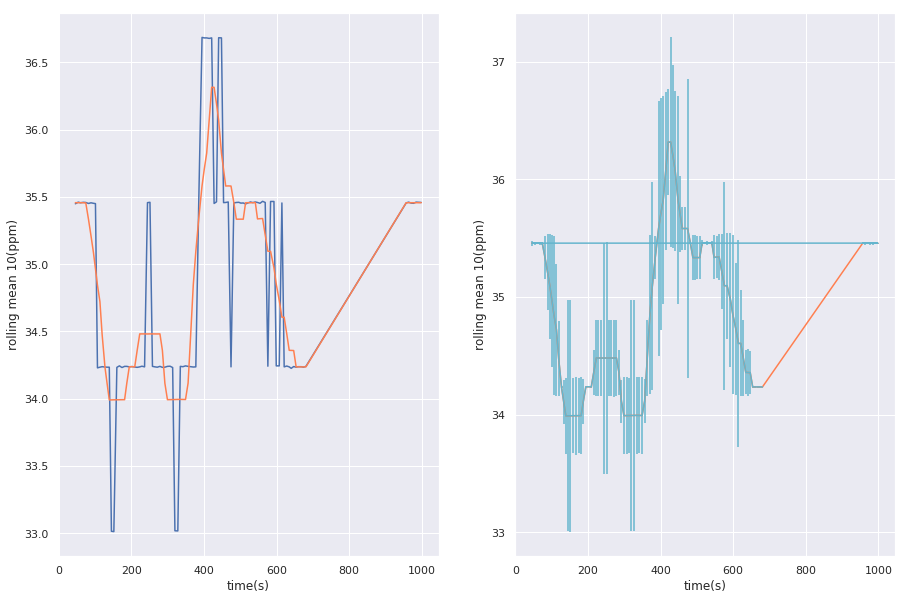

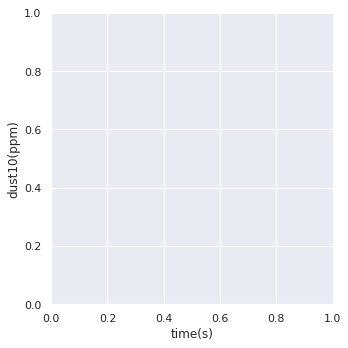

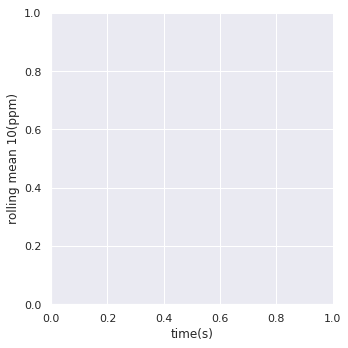

In [33]:
#create charts
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 10))
sns.set(style="darkgrid")
#Plot against dust (line)
sns.relplot(x="time(s)", y="dust10(ppm)",kind="line",data=df,ax=ax1)
sns.relplot(x="time(s)", y="rolling mean 10(ppm)",kind="line",color="coral",data=df,ax=ax1)
sns.lineplot(x="time(s)", y="rolling mean 10(ppm)",color="coral",data=df,ax=ax2)
ax2.errorbar(df["time(s)"],y=df["rolling mean 10(ppm)"],yerr=df["error10"],color="c")

In [37]:
df.to_pickle("./data/test1.pkl")